# Set up

## Import Libraries

In [94]:
import os
import pandas as pd
import numpy as np
from textwrap import wrap
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import statsmodels.api as sm
from scipy import stats

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error
from sklearn.feature_selection import RFE

rnd = 101

## Load Data

In [95]:
# Load data
data = pd.read_csv(".\\Data\\data.csv")
data.head(5)

,age,gender,chest_pain_type,rest_blood_pressure,cholesterol,fast_blood_sugar,rest_ecg,max_heart_rate,ex_ind_ang,prev_peak,slope,vessels_num,thal_result,output
0,63,1,Non-anginal pain,145,233,Yes,Normal,150,No,2.3,0,0,1,1
1,37,1,Atypical angina,130,250,No,ST-T wave normality,187,No,3.5,0,0,2,1
2,41,0,Typical angina,130,204,No,Normal,172,No,1.4,2,0,2,1
3,56,1,Typical angina,120,236,No,ST-T wave normality,178,No,0.8,2,0,2,1
4,57,0,NaN,120,354,No,ST-T wave normality,163,Yes,0.6,2,0,2,1


# Data Preparation

## Data Summary

In [96]:
print(data.info())
print(data.describe())
# create helper arrays
dv = ['output']
numeric = list(data._get_numeric_data().columns.values)
character = [var for var in data.columns if var not in numeric]
discrete = ['gender','slope','vessels_num','thal_result']
contin = [var for var in data.columns if var not in dv+character+discrete]
print("Dependent variable: ", dv, "\n", 
      "Numeric variables: ", numeric, "\n", 
      "Categorical variables: ", character, "\n", 
      "Descrete variables: ", discrete, "\n", 
      "Continous variables: ", contin)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  303 non-null    int64  
 1   gender               303 non-null    int64  
 2   chest_pain_type      160 non-null    object 
 3   rest_blood_pressure  303 non-null    int64  
 4   cholesterol          303 non-null    int64  
 5   fast_blood_sugar     303 non-null    object 
 6   rest_ecg             303 non-null    object 
 7   max_heart_rate       303 non-null    int64  
 8   ex_ind_ang           303 non-null    object 
 9   prev_peak            303 non-null    float64
 10  slope                303 non-null    int64  
 11  vessels_num          303 non-null    int64  
 12  thal_result          303 non-null    int64  
 13  output               303 non-null    int64  
dtypes: float64(1), int64(9), object(4)
memory usage: 33.3+ KB
None
              age      gend

Data contains categorical and numerical variables. Dependent variable, 'output', has binary format. Missing values present for one of the variables (chest_pain_type ), missing for almost half of the data. There are possible outliers in high cholesterol values.

## EDA

In [97]:
def plot_categorical(df,xvar,by,kind='count'):
    sns.catplot(x= xvar, kind=kind, hue=by, data=df)
    plt.tick_params(axis='x', which='major', pad=10, labelrotation=-55)
    plt.title('Frequency by '+ xvar)
    var_labels = data[xvar].unique().astype('str')
    labels = ['\n'.join(wrap(l,12)) for l in pd.Series(var_labels)]
    plt.xticks(list(range(0,len(var_labels))),labels)
    plt.ylabel('Frequencies', fontsize=12)
    plt.xlabel(xvar, fontsize=12)
    plt.show()

### Categorical

In [98]:
# Almost half of 'chest_pain_type' is missing - set them to a separate category for now 
# (those could be asymptomatic cases according to the table description or a mix of asymptomatic and missing. 
# will keep them as a "missing" category)
data1 = data.copy()
data1["chest_pain_type"] = data1["chest_pain_type"].fillna("Missing")
data1[character].describe()

,chest_pain_type,fast_blood_sugar,rest_ecg,ex_ind_ang
count,303,303,303,303
unique,4,2,3,2
top,Missing,No,ST-T wave normality,No
freq,143,258,152,204


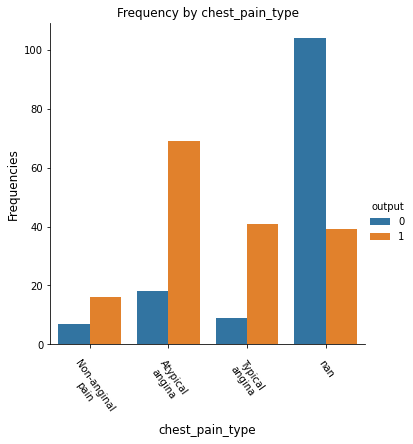

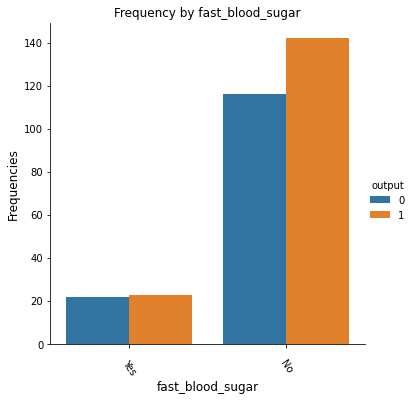

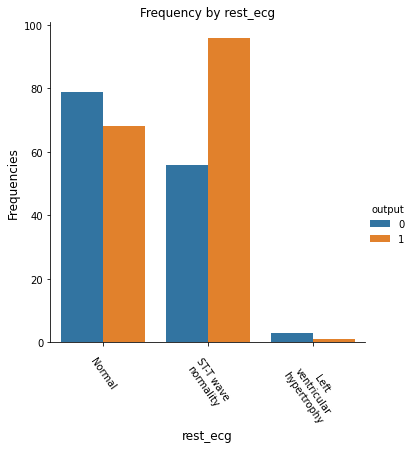

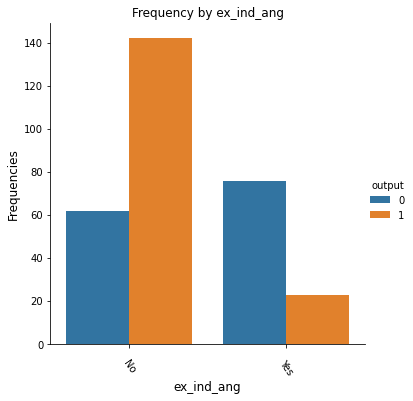

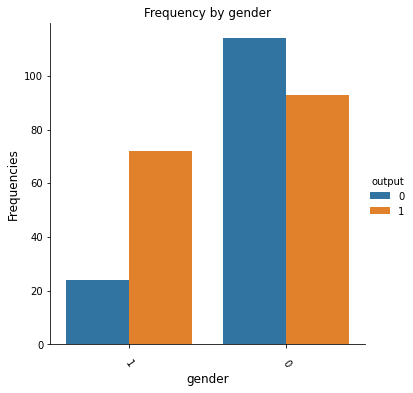

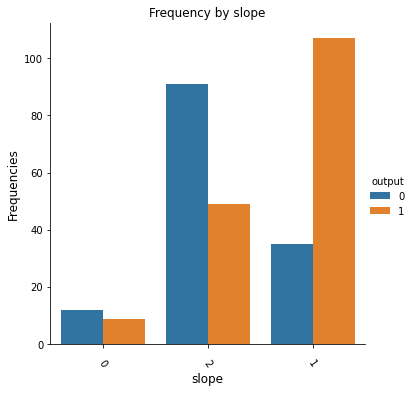

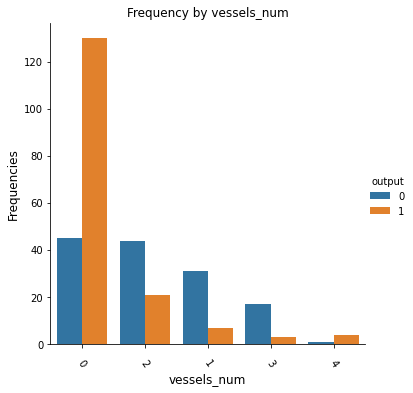

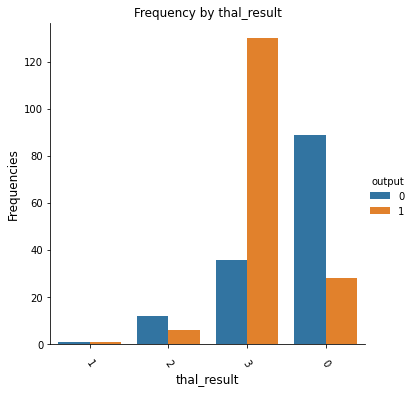

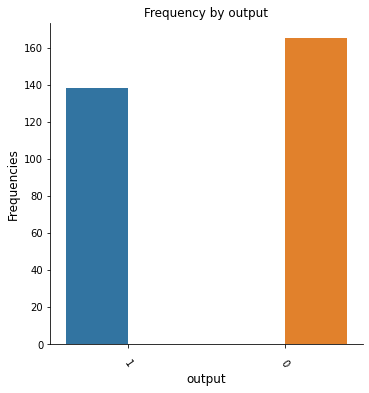

In [99]:
# Plot frequencies of categotical variables
for var in character+discrete+dv:
    plot_categorical(data1,var,'output')

Dataset has approximately balanced number of both types of output. Some categorical variables (vessels_num, thal_result) may be good predictors for the the output. 

In [100]:
# Some categories have very low volumes with 1-2% (2-5 obs) of population in.
# These variables won't play significant role in explaining dependnet variable.
# -> merge them on with other category within same variable that have a similar distribution of dependent variable.
print(pd.crosstab(data1.rest_ecg, data1.output))
print(pd.crosstab(data1.vessels_num, data1.output))
print(pd.crosstab(data1.thal_result, data1.output))

data2 = data1.copy()
data2.loc[data2.rest_ecg=='Left ventricular hypertrophy','rest_ecg'] = 'Normal'
data2.loc[data2.vessels_num==4,'vessels_num'] = 0
data2.loc[data2.thal_result==0,'thal_result'] = 1

print(pd.crosstab(data2.rest_ecg, data2.output))
print(pd.crosstab(data2.vessels_num, data2.output))
print(pd.crosstab(data2.thal_result, data2.output))

output                         0   1
rest_ecg                            
Left ventricular hypertrophy   3   1
Normal                        79  68
ST-T wave normality           56  96
output        0    1
vessels_num         
0            45  130
1            44   21
2            31    7
3            17    3
4             1    4
output        0    1
thal_result         
0             1    1
1            12    6
2            36  130
3            89   28
output                0   1
rest_ecg                   
Normal               82  69
ST-T wave normality  56  96
output        0    1
vessels_num         
0            46  134
1            44   21
2            31    7
3            17    3
output        0    1
thal_result         
1            13    7
2            36  130
3            89   28


### Numeric

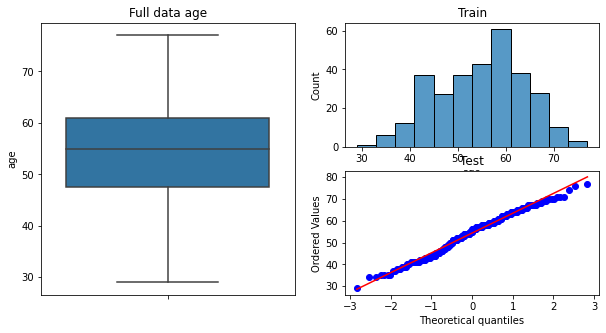

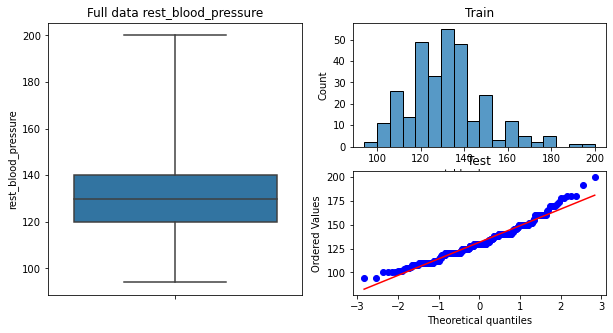

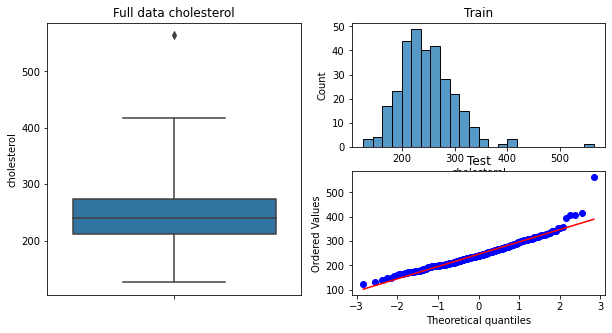

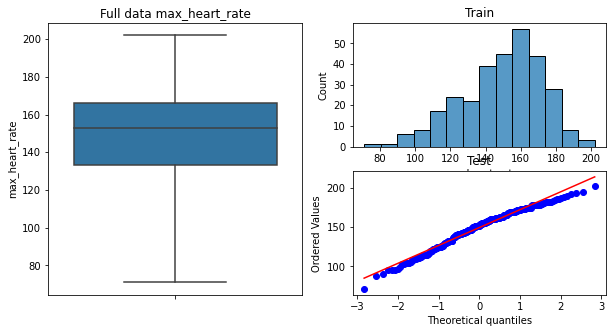

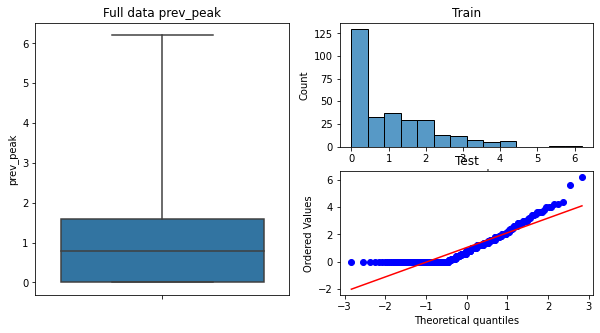

In [101]:
for var in contin:
    fig = plt.figure(figsize=(10, 5))
    gs = GridSpec(nrows=2, ncols=2)
    ax0 = fig.add_subplot(gs[0, 1])
    sns.histplot(data2, x=var, ax=ax0)
    ax0.title.set_text('Train')
    ax1 = fig.add_subplot(gs[1, 1])
    stats.probplot(data2.loc[:,var], plot=plt)
    ax1.title.set_text('Test')
    ax2 = fig.add_subplot(gs[:, 0])
    #sns.boxplot(y=var, hue=None, whis=1.5, data=data2, ax=ax2)
    sns.boxplot(y=var, hue=None, whis=3, data=data2, ax=ax2)
    ax2.title.set_text('Full data ' + var)

The distribution of numeric variables is approximately normal, with exception of prev_peak. Light and heavy tails can be observed as well as some points lying outside of 1.5*IQR. This could be due to a low volume of observations. Increasing the range to 3*IQR leaves us with one point outside on the 'cholesterol' box plot. This point also stands out on the QQ plot.

In [102]:
# Check the observations with point outside 3*IQR individually. 
print(data2.sort_values('cholesterol', ascending=False)[:1])

    age  gender  chest_pain_type  rest_blood_pressure  cholesterol  \
85   67       0  Atypical angina                  115          564   

   fast_blood_sugar rest_ecg  max_heart_rate ex_ind_ang  prev_peak  slope  \
85               No   Normal             160         No        1.6      1   

    vessels_num  thal_result  output  
85            0            3       1  


In [103]:
# Without better knowledge of underlying data it is unclear if the values for potential outlier make sense.
# Since the max cholesterol value is far outside of 3*IQR with distribution being approximately normal we will remove that point.
data3 = data2.drop(85).copy().reset_index(drop=True)
print(data3.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302 entries, 0 to 301
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  302 non-null    int64  
 1   gender               302 non-null    int64  
 2   chest_pain_type      302 non-null    object 
 3   rest_blood_pressure  302 non-null    int64  
 4   cholesterol          302 non-null    int64  
 5   fast_blood_sugar     302 non-null    object 
 6   rest_ecg             302 non-null    object 
 7   max_heart_rate       302 non-null    int64  
 8   ex_ind_ang           302 non-null    object 
 9   prev_peak            302 non-null    float64
 10  slope                302 non-null    int64  
 11  vessels_num          302 non-null    int64  
 12  thal_result          302 non-null    int64  
 13  output               302 non-null    int64  
dtypes: float64(1), int64(9), object(4)
memory usage: 33.2+ KB
None


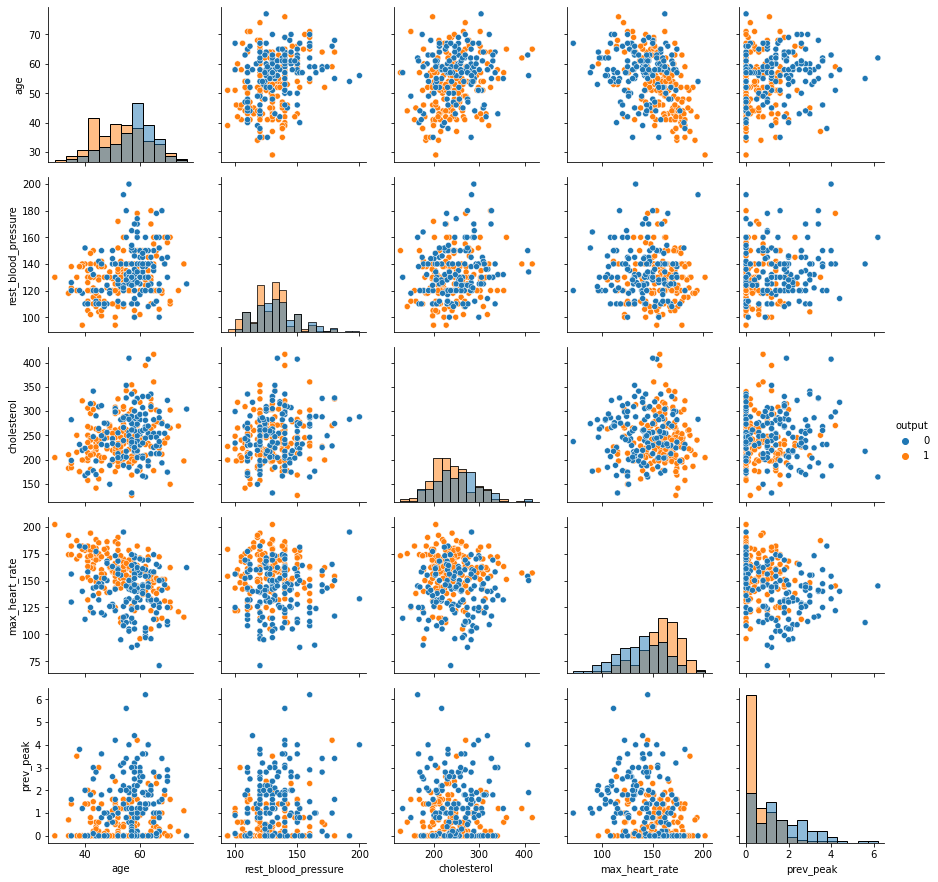

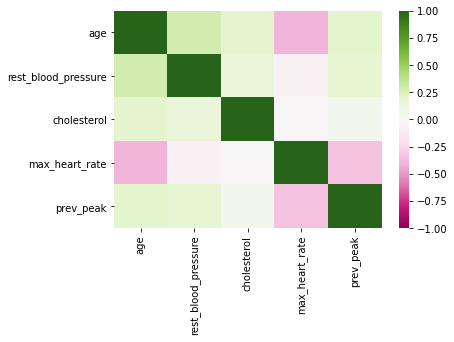

In [104]:
# Pairplots by outcome
#g = sns.PairGrid(data[numeric])
g = sns.PairGrid(data3[contin+dv], hue='output')
#g = sns.PairGrid(data2[contin+['gender']], hue='gender')
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()
plt.show()
# Correlation
corr = data3[contin].corr()
sns.heatmap(corr, vmin=-1, vmax=1, cmap="PiYG")
plt.show()

There is no strong correlation between any pair of variables. There aloso doesn't appear to be strong relationship between dependent variable and continuous predictors.

## Train - test split

Split the data into train and test dataset in a 70/30 ratio. Omit validation split due to low volumes. 

### Split dataset

In [105]:
X_train, X_test, y_train, y_test = train_test_split(data3.drop('output',axis=1), 
                                                    data3['output'], 
                                                    test_size=0.30, 
                                                    random_state=rnd)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(211, 13) (211,)
(91, 13) (91,)


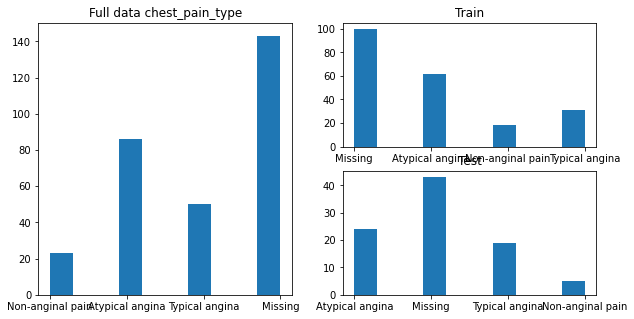

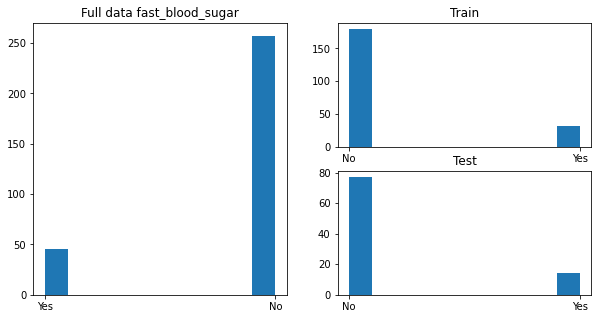

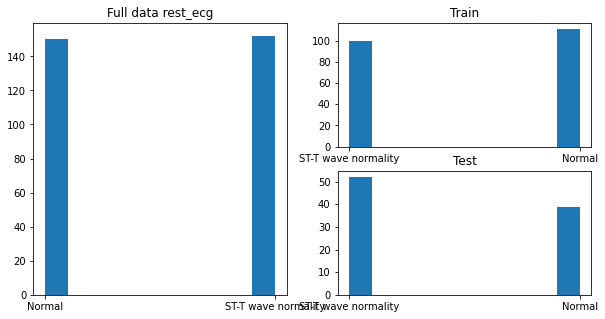

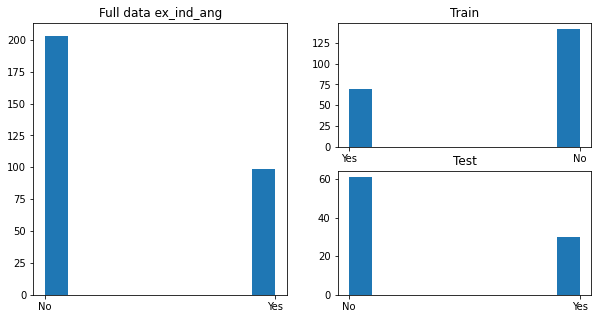

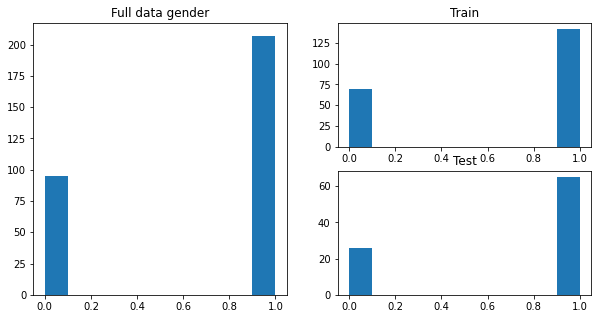

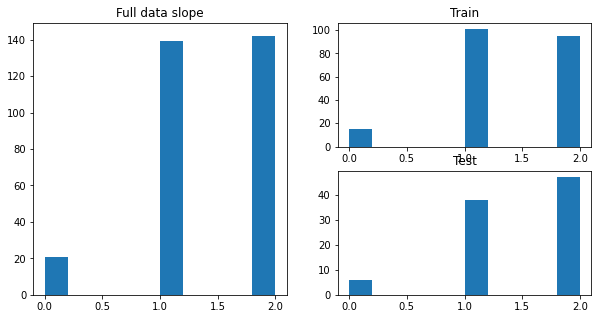

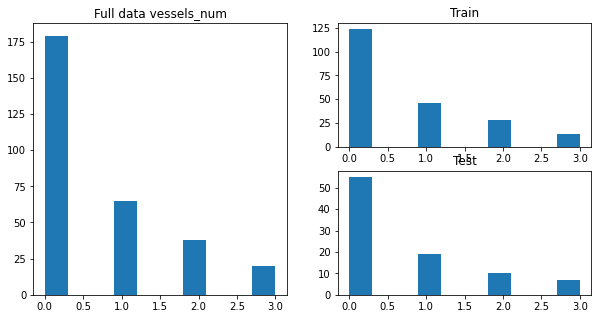

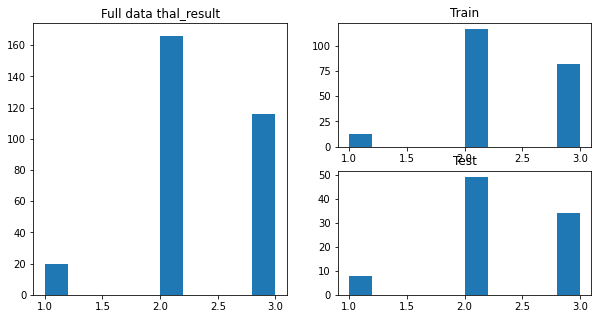

In [106]:
# Check distributions
for var in character+discrete:
    fig = plt.figure(figsize=(10, 5))
    gs = GridSpec(nrows=2, ncols=2)
    ax0 = fig.add_subplot(gs[0, 1])
    ax0.hist(X_train[var])
    ax0.title.set_text('Train')
    ax1 = fig.add_subplot(gs[1, 1])
    ax1.hist(X_test[var])
    ax1.title.set_text('Test')
    ax2 = fig.add_subplot(gs[:, 0])
    ax2.hist(data3[var])
    ax2.title.set_text('Full data ' + var)

# the train-test split seem to preserve distribution within categorical and dependent variables

In [107]:
# Convert categorical to dummy variables. Other discrete vars are ordinal - leave as is.
one_hot1 = pd.get_dummies(X_train[character], drop_first=True)
one_hot2 = pd.get_dummies(X_test[character], drop_first=True)

X_train_oh = X_train.drop(character,axis = 1) 
X_test_oh = X_test.drop(character,axis = 1)

X_train_oh = X_train_oh.join(one_hot1).reset_index(drop=True)
print(X_train.shape)
X_test_oh = X_test_oh.join(one_hot2).reset_index(drop=True)
print(X_test_oh.shape)

(211, 13)
(91, 15)


In [108]:
# Standardise the data
scaler = StandardScaler().fit(X_train_oh)
X_train_s = pd.DataFrame(scaler.transform(X_train_oh),columns=X_train_oh.columns)
X_test_s = pd.DataFrame(scaler.transform(X_test_oh),columns=X_test_oh.columns)

### Check variable importance

Feature 0: 4.142351
Feature 1: 7.356337
Feature 2: 61.998317
Feature 3: 4.922232
Feature 4: 33.921049
Feature 5: 2.162860
Feature 6: 10.456355
Feature 7: 0.119443
Feature 8: 1.465917
Feature 9: 25.658078


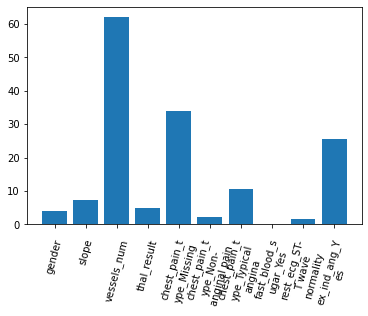

['vessels_num' 'chest_pain_type_Missing' 'chest_pain_type_Typical angina'
 'ex_ind_ang_Yes']


In [109]:
# Use shi-squared test for categorical data
# Select categorical columns converted to dummies
X_train_enc = X_train[discrete].join(one_hot1).reset_index(drop=True)
X_test_enc = X_test[discrete].join(one_hot2).reset_index(drop=True)

# Calculate scores
fs = SelectKBest(score_func=chi2, k='all')
fs.fit(X_train_enc, y_train)

# Print scores for the features
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))
# Plot scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.tick_params(axis='x', which='major', pad=10, labelrotation=75)
labels = ['\n'.join(wrap(l,12)) for l in pd.Series(X_train_enc.columns)]
plt.xticks(list(range(0,len(X_train_enc.columns))),labels)
plt.show()

# Select important categorical vars
char_importance = X_train_enc.columns[fs.scores_>10].values
print(char_importance)

Feature 0: 11.597279
Feature 1: 1.387711
Feature 2: 1.216642
Feature 3: 40.879071
Feature 4: 56.673258


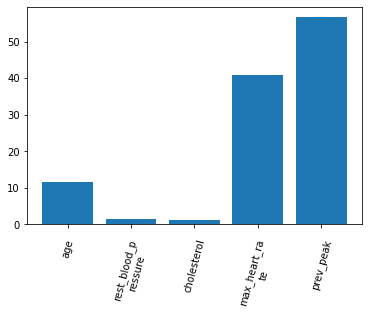

['age' 'max_heart_rate' 'prev_peak']


In [110]:
# Use ANOVA for numeric variables
# Get f-scores
fs = SelectKBest(score_func=f_classif, k='all')
fs.fit(X_train[contin], y_train)

# Print scores for the features
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))
# Plot scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.tick_params(axis='x', which='major', pad=10, labelrotation=75)
labels = ['\n'.join(wrap(l,12)) for l in pd.Series(X_train[contin].columns)]
plt.xticks(list(range(0,len(X_train[contin].columns))),labels)
plt.show()

# Select important numeric vars
num_importance = X_train[contin].columns[fs.scores_>10].values
print(num_importance)

# Models

The objective for the models is to predict low/high risk of heart attack based on the available characteristics. For this classification problem we will explore 5 model options: decision teree, random forest, logistic regression, kNN, SVM.
For measurment of models performance and comparison we will be using confusion matrix, where accuracy measures ratio of correctly identified cases, precision - ratio of correctly identified positive cases (0) out of all positive identified, recall - ratio of all negative (1) cases out of all negative identified and f1-score - combination of precision and recall for accuracy measure on inbalanced dataset (less relevant in this case).
To tune hyperparameters we will use grid search where relevant.

In [111]:
# Create table for final results
results = pd.DataFrame(columns = ["Accuracy","Precision","Recall","F1"], 
                       index = ["DTree","RFC","Logistic","kNN","SVM"])

## Decision Tree

Train accuracy:  1.0
Test accuracy:  0.7692307692307693
              precision    recall  f1-score   support

           0       0.82      0.65      0.73        43
           1       0.74      0.88      0.80        48

    accuracy                           0.77        91
   macro avg       0.78      0.76      0.76        91
weighted avg       0.78      0.77      0.77        91



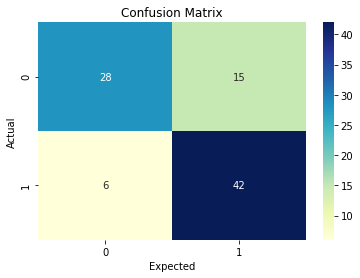

In [112]:
# Fit full decision tree
dtree_full = tree.DecisionTreeClassifier(random_state=rnd)
dtree_full.fit(X_train_oh,y_train)

# Get accuracy
train_dtree_full = dtree_full.predict(X_train_oh)
test_dtree_full = dtree_full.predict(X_test_oh)

# Output results
print("Train accuracy: ", accuracy_score(y_train, train_dtree_full))
print("Test accuracy: ", accuracy_score(y_test, test_dtree_full))
print(classification_report(y_test,test_dtree_full))
sns.heatmap(confusion_matrix(y_test, test_dtree_full), annot=True, cmap="YlGnBu")
plt.ylabel("Actual")
plt.xlabel("Expected")
plt.title("Confusion Matrix")
plt.show()

The tree has a 100% accuracy on the train set vs 78% on the test set and clearly overfitted -> reduce complexity with pruning.

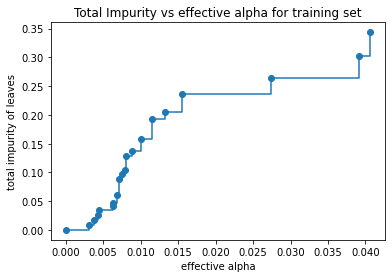

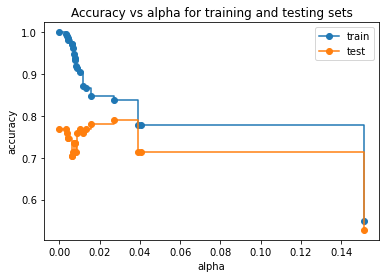

In [113]:
# Prune the tree
# Get cost-complexity alphas
path = dtree_full.cost_complexity_pruning_path(X_train_oh, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

# Iterate through alphas to get accuracy
dtrees = []
for ccp_alpha in ccp_alphas:
    dtree = tree.DecisionTreeClassifier(random_state=rnd, ccp_alpha=ccp_alpha)
    dtree.fit(X_train_oh, y_train)
    dtrees.append(dtree)

train_scores = [tree.score(X_train_oh, y_train) for tree in dtrees]
test_scores = [tree.score(X_test_oh, y_test) for tree in dtrees]

# Plot alpha vs accuracy
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

Alpha is a complexity penalty. We select alpha that maximizes test accuracy.

Train accuracy:  0.8388625592417062
Test accuracy:  0.7912087912087912
              precision    recall  f1-score   support

           0       0.90      0.63      0.74        43
           1       0.74      0.94      0.83        48

    accuracy                           0.79        91
   macro avg       0.82      0.78      0.78        91
weighted avg       0.81      0.79      0.79        91



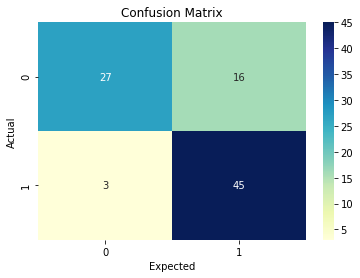

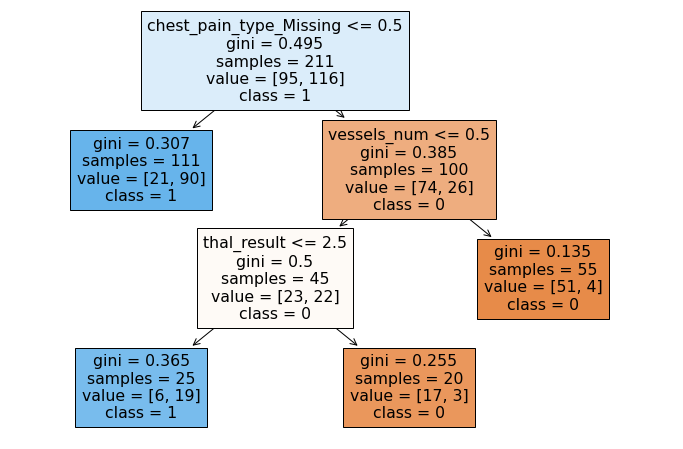

In [114]:
# Fit trimmed decision tree
dtree_trim = tree.DecisionTreeClassifier(ccp_alpha=ccp_alphas[-4], random_state=rnd)
dtree_trim.fit(X_train_oh,y_train)

# Get accuracy
train_dtree_trim = dtree_trim.predict(X_train_oh)
test_dtree_trim = dtree_trim.predict(X_test_oh)

# Output results
print("Train accuracy: ", accuracy_score(y_train, train_dtree_trim))
print("Test accuracy: ", accuracy_score(y_test, test_dtree_trim))
print(classification_report(y_test,test_dtree_trim))
sns.heatmap(confusion_matrix(y_test, test_dtree_trim), annot=True, cmap="YlGnBu")
plt.ylabel("Actual")
plt.xlabel("Expected")
plt.title("Confusion Matrix")
plt.show()

fig = plt.figure(figsize=(12,8))
_ = tree.plot_tree(dtree_trim, 
                   feature_names=X_train_oh.columns,  
                   class_names=["0", "1"],
                   filled=True)


cm = confusion_matrix(y_test, test_dtree_trim)
results.loc["DTree","Accuracy"] = accuracy_score(y_test, test_dtree_trim)
results.loc["DTree","Precision"] = cm[0,0]/(cm[0,0]+cm[1,0])
results.loc["DTree","Recall"] = cm[1,1]/(cm[0,1]+cm[1,1])
results.loc["DTree","F1"] = 2*results.loc["DTree","Precision"]*results.loc["DTree","Recall"]/(results.loc["DTree","Precision"]+results.loc["DTree","Recall"])

Trimmed tree has an improved test accuracy (0.79), precision (0.90) and recall (0.74) scores. Three variables are used for the final tree: chest_pain_type, vessels_num and thal_result. The gini impurity at each leaf is within [0.135, 0.365] range.

## Random Forest

In [115]:
# Sample random forest
rfc = RandomForestClassifier(max_depth=3, max_features=4, random_state=rnd)
rfc.fit(X_train_oh, y_train)

pred_rfc = rfc.predict(X_test_oh)
print(confusion_matrix(y_test, pred_rfc))
print(classification_report(y_test, pred_rfc))
print(accuracy_score(y_test, pred_rfc))

[[31 12]
 [ 3 45]]
              precision    recall  f1-score   support

           0       0.91      0.72      0.81        43
           1       0.79      0.94      0.86        48

    accuracy                           0.84        91
   macro avg       0.85      0.83      0.83        91
weighted avg       0.85      0.84      0.83        91

0.8351648351648352


In [116]:
# Iterate over set of hyperparameters:
# Create the parameters grid
param_grid = { 'max_depth': [x+1 for x in range(10)],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [2, 3, 5],
               'bootstrap': [True, False]}
print(param_grid)

# Grid Search
rfc_grid = RandomForestClassifier(random_state=rnd)
grid_search = GridSearchCV(rfc_grid, param_grid=param_grid, scoring='accuracy')
grid_search.fit(X_train_oh, y_train)

# Output best model
best_rfc = grid_search.best_params_
print(best_rfc)
best_result = grid_search.best_score_
print(best_result)

{'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [2, 3, 5], 'bootstrap': [True, False]}
{'bootstrap': True, 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2}
0.853045404208195


Train accuracy:  0.8625592417061612
Test accuracy:  0.8351648351648352
              precision    recall  f1-score   support

           0       0.91      0.72      0.81        43
           1       0.79      0.94      0.86        48

    accuracy                           0.84        91
   macro avg       0.85      0.83      0.83        91
weighted avg       0.85      0.84      0.83        91



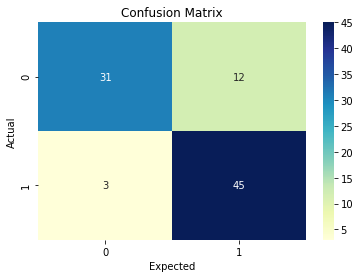

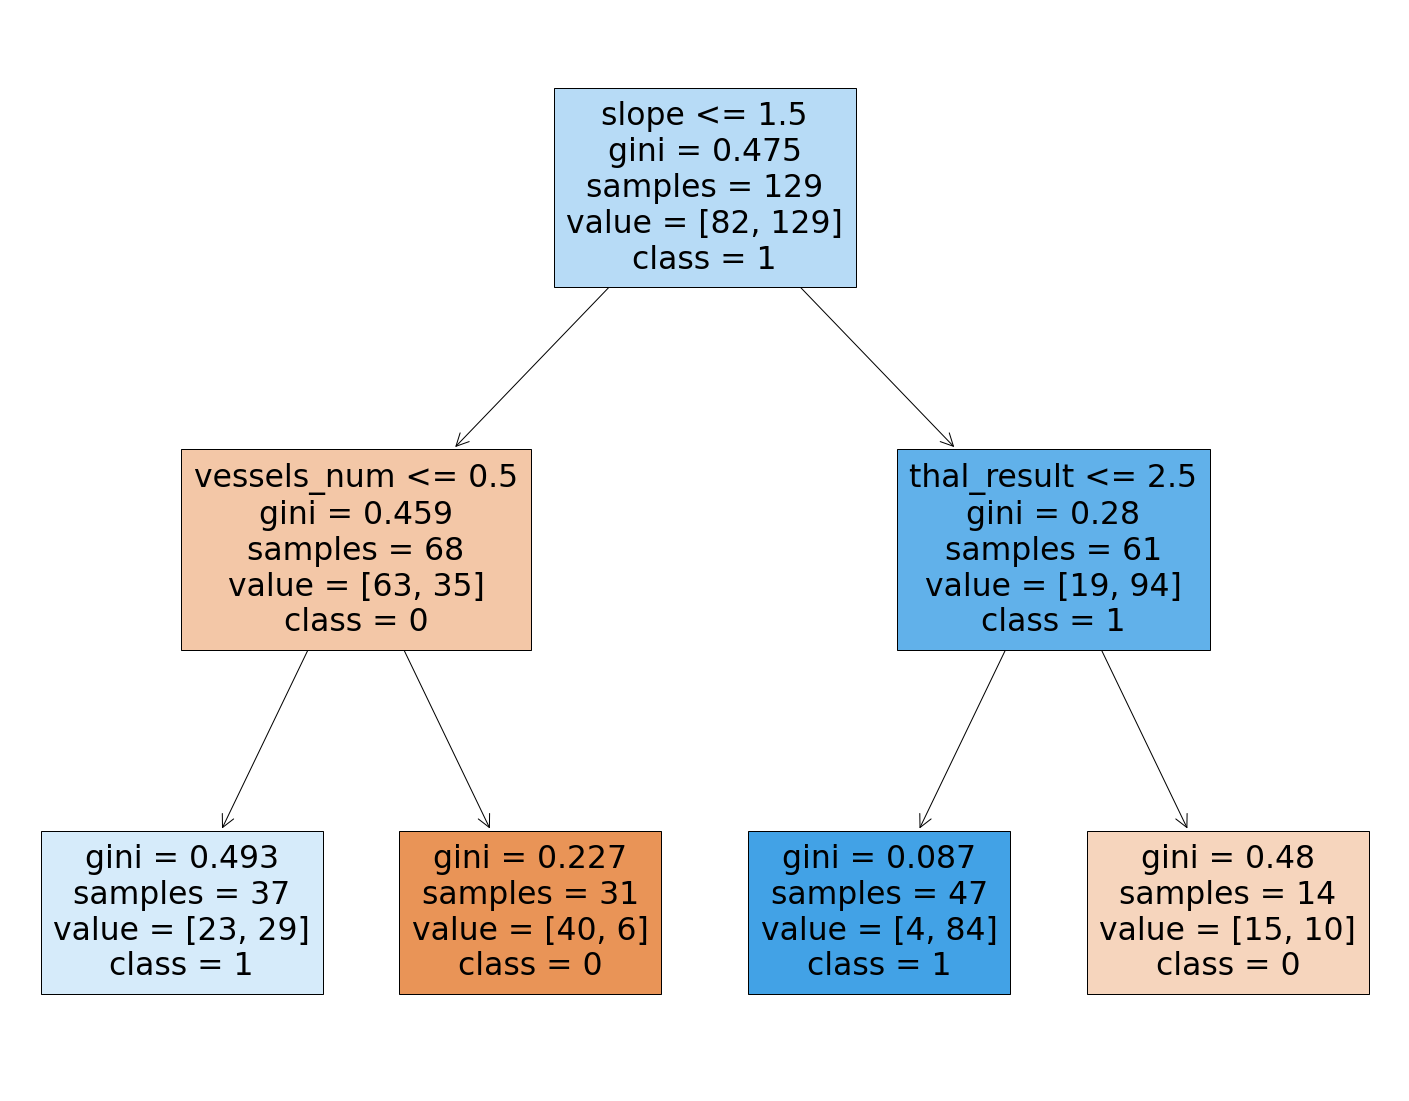

In [117]:
# Evaluate on test data
best_est = grid_search.best_estimator_
train_best_rfc = best_est.predict(X_train_oh)
test_best_rfc = best_est.predict(X_test_oh)

# Output results
print("Train accuracy: ", accuracy_score(y_train, train_best_rfc))
print("Test accuracy: ", accuracy_score(y_test, test_best_rfc))
print(classification_report(y_test,test_best_rfc))

sns.heatmap(confusion_matrix(y_test, test_best_rfc), annot=True, cmap="YlGnBu")
plt.ylabel("Actual")
plt.xlabel("Expected")
plt.title("Confusion Matrix")
plt.show()

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(grid_search.best_estimator_.estimators_[0], 
                   feature_names=X_train_oh.columns,  
                   class_names=["0", "1"],
                   filled=True)


cm = confusion_matrix(y_test, test_best_rfc)
results.loc["RFC","Accuracy"] = accuracy_score(y_test, test_best_rfc)
results.loc["RFC","Precision"] = cm[0,0]/(cm[0,0]+cm[1,0])
results.loc["RFC","Recall"] = cm[1,1]/(cm[0,1]+cm[1,1])
results.loc["RFC","F1"] = 2*results.loc["RFC","Precision"]*results.loc["RFC","Recall"]/(results.loc["RFC","Precision"]+results.loc["RFC","Recall"])

Random forest shows almost 5% improvement in accuracy (0.84) on the test data, comparing to the singe tree model, as well as better precision (0.91) and recall (0.79). 

## Logistic Regression

In [118]:
# Fit model with all variables
logreg=sm.Logit(list(y_train),sm.add_constant(X_train_s),random_state=rnd)
logit_model0=logreg.fit()
print(logit_model0.summary())

logreg_pred = logit_model0.predict(sm.add_constant(X_test_s))
print(confusion_matrix(y_test, round(logreg_pred)))
print(classification_report(y_test, round(logreg_pred)))
print(accuracy_score(y_test, round(logreg_pred)))

Optimization terminated successfully.
         Current function value: 0.323217
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  211
Model:                          Logit   Df Residuals:                      195
Method:                           MLE   Df Model:                           15
Date:                Sun, 01 Aug 2021   Pseudo R-squ.:                  0.5303
Time:                        22:02:29   Log-Likelihood:                -68.199
converged:                       True   LL-Null:                       -145.21
Covariance Type:            nonrobust   LLR p-value:                 3.835e-25
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                                0.1564      0.239      0.65

A model with all independent variables included resulted in accuracy of 88%. The coefficient table shows that only few parameters are significant (at 5% significance level): vessels_num, thal_result, gender, chest_pain_type and ex_ind_ang. We will try three ways to reduce complexity: drop insignificant variables, recursive feature elimination and regularisation.

Optimization terminated successfully.
         Current function value: 0.366206
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  211
Model:                          Logit   Df Residuals:                      206
Method:                           MLE   Df Model:                            4
Date:                Sun, 01 Aug 2021   Pseudo R-squ.:                  0.4679
Time:                        22:02:29   Log-Likelihood:                -77.269
converged:                       True   LL-Null:                       -145.21
Covariance Type:            nonrobust   LLR p-value:                 2.155e-28
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
vessels_num                -1.2430      0.254     -4.895      0.000      -1.741   

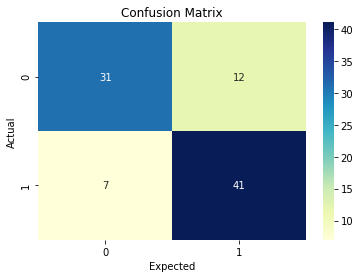

In [119]:
# 1. Keep only significant features
features1 = ['vessels_num','thal_result','gender','chest_pain_type_Missing',
            'ex_ind_ang_Yes']
logreg1=sm.Logit(list(y_train),X_train_s[features1],random_state=rnd)
logit_model1=logreg1.fit()
print(logit_model1.summary())

# Get accuracy
train_logreg1 = logit_model1.predict(X_train_s[features1])
test_logreg1 = logit_model1.predict(X_test_s[features1])

# Output results
print("Train accuracy: ", accuracy_score(y_train, np.round(train_logreg1)))
print("Test accuracy: ", accuracy_score(y_test, np.round(test_logreg1)))
print(classification_report(y_test,np.round(test_logreg1)))
sns.heatmap(confusion_matrix(y_test, np.round(test_logreg1)), annot=True, cmap="YlGnBu")
plt.ylabel("Actual")
plt.xlabel("Expected")
plt.title("Confusion Matrix")
plt.show()

12
                            features      coef
0                                age -0.076334
1                             gender -0.616680
2                rest_blood_pressure -0.172755
3                        cholesterol -0.530019
4                     max_heart_rate  0.540392
5                          prev_peak -1.192221
6                              slope -0.659460
7                        vessels_num -1.234647
8                        thal_result -0.462735
9            chest_pain_type_Missing  0.246762
10  chest_pain_type_Non-anginal pain  0.157377
11    chest_pain_type_Typical angina -0.498857
Train accuracy:  0.8767772511848341
Test accuracy:  0.8791208791208791
              precision    recall  f1-score   support

           0       0.92      0.81      0.86        43
           1       0.85      0.94      0.89        48

    accuracy                           0.88        91
   macro avg       0.89      0.88      0.88        91
weighted avg       0.88      0.88      0.88

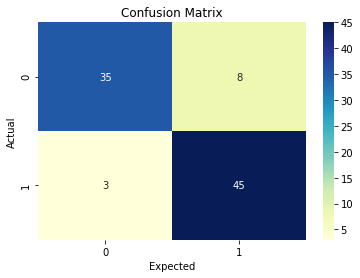

In [120]:
# 2. Recursive feature elimination
logreg2 = LogisticRegression(penalty='none',random_state=rnd)
logit_model2 = logreg2.fit(X_train_s, y_train)
rfe = RFE(estimator=logit_model2)
rfe = rfe.fit(X_train_s, y_train)

# Iterate over set of hyperparameters:
# Create the parameters grid
param_grid = { 'n_features_to_select': [x+1 for x in range(15)]}

# Grid Search
grid_search = GridSearchCV(rfe, param_grid=param_grid, scoring='accuracy')
grid_search.fit(X_train_s, y_train)

# Output best model
best_n = grid_search.best_estimator_.get_params()['n_features_to_select']
print(best_n)

# Evaluate on train and test data
rfe = RFE(estimator=logit_model2, n_features_to_select=best_n)
rfe = rfe.fit(X_train_s, y_train)
features2 = list(X_train_s.columns[rfe.support_].values)
logit_model2 = logreg2.fit(X_train_s[features2], y_train)
print(pd.DataFrame(zip(X_train_s.columns, np.transpose(logit_model2.coef_.tolist()[0])), columns=['features', 'coef']))

train_logreg2 = logit_model2.predict(X_train_s[features2])
test_logreg2 = logit_model2.predict(X_test_s[features2])

# Output results
print("Train accuracy: ", accuracy_score(y_train, np.round(train_logreg2)))
print("Test accuracy: ", accuracy_score(y_test, np.round(test_logreg2)))
print(classification_report(y_test,np.round(test_logreg2)))

sns.heatmap(confusion_matrix(y_test, np.round(test_logreg2)), annot=True, cmap="YlGnBu")
plt.ylabel("Actual")
plt.xlabel("Expected")
plt.title("Confusion Matrix")
plt.show()

Best l: l2
Best c: 0.01
                            features      coef
0                                age -0.074296
1                             gender -0.135073
2                rest_blood_pressure -0.021956
3                        cholesterol -0.025694
4                     max_heart_rate  0.145640
5                          prev_peak -0.190113
6                              slope  0.136011
7                        vessels_num -0.241031
8                        thal_result -0.197525
9            chest_pain_type_Missing -0.264003
10  chest_pain_type_Non-anginal pain  0.047792
11    chest_pain_type_Typical angina  0.065636
12              fast_blood_sugar_Yes  0.032367
13      rest_ecg_ST-T wave normality  0.042779
14                    ex_ind_ang_Yes -0.176080
Train accuracy:  0.8625592417061612
Test accuracy:  0.8571428571428571
              precision    recall  f1-score   support

           0       0.89      0.79      0.84        43
           1       0.83      0.92      0.87 

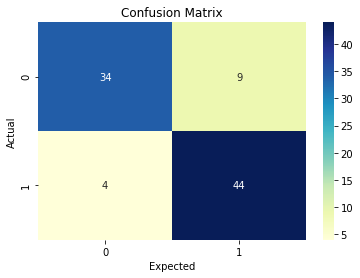

In [121]:
# 3. Regularization
logreg3=LogisticRegression(solver='liblinear',random_state=rnd)

# Iterate over set of hyperparameters:
# Create the parameters grid
param_grid = {'penalty': ['l1','l2'], 'C': [0.1,0.01,0.001]}

# Grid Search
grid_search = GridSearchCV(logreg3, param_grid=param_grid, scoring='accuracy')
grid_search.fit(X_train_s, y_train)


best_l = grid_search.best_estimator_.get_params()['penalty']
best_c = grid_search.best_estimator_.get_params()['C']
print('Best l:', best_l)
print('Best c:', best_c)

# Fit best model
logreg3=LogisticRegression(penalty=best_l,C=best_c,solver='liblinear',random_state=rnd)
logit_model3 = logreg3.fit(X_train_s, y_train)
print(pd.DataFrame(zip(X_train_s.columns, np.transpose(logit_model3.coef_.tolist()[0])), columns=['features', 'coef']))

train_logreg3 = grid_search.predict(X_train_s)
test_logreg3 = grid_search.predict(X_test_s)

# Output results
print("Train accuracy: ", accuracy_score(y_train, np.round(train_logreg3)))
print("Test accuracy: ", accuracy_score(y_test, np.round(test_logreg3)))
print(classification_report(y_test,np.round(test_logreg3)))

sns.heatmap(confusion_matrix(y_test, np.round(test_logreg3)), annot=True, cmap="YlGnBu")
plt.ylabel("Actual")
plt.xlabel("Expected")
plt.title("Confusion Matrix")
plt.show()

cm = confusion_matrix(y_test, test_logreg3)
results.loc["Logistic","Accuracy"] = accuracy_score(y_test, test_logreg3)
results.loc["Logistic","Precision"] = cm[0,0]/(cm[0,0]+cm[1,0])
results.loc["Logistic","Recall"] = cm[1,1]/(cm[0,1]+cm[1,1])
results.loc["Logistic","F1"] = 2*results.loc["Logistic","Precision"]*results.loc["Logistic","Recall"]/(results.loc["Logistic","Precision"]+results.loc["Logistic","Recall"])

Among three options, the RFE veraibles eliminationshows better accuracy result of 88% after removing 2 and leaving 12 variables form the dataset. Significance based elimination shows worse accuracy (79%) but has a higher complexity reduction. Ridge regression shows an average result with weights reduced for non-significant predictors. Keep Ridge results for comparison.

## kNN

In [122]:
# Iterate over set of hyperparameters:
# Create the parameters grid
param_grid = {'n_neighbors': [x+1 for x in range(20)], 'p': [2]}

# Create grid object
knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, param_grid)

grid_model_knn = knn_grid.fit(X_train_s,y_train)
best_k = grid_model_knn.best_estimator_.get_params()['n_neighbors']
print('Best n_neighbors:', best_k)

Best n_neighbors: 11


Train accuracy:  0.8720379146919431
Test accuracy:  0.8351648351648352
              precision    recall  f1-score   support

           0       0.89      0.74      0.81        43
           1       0.80      0.92      0.85        48

    accuracy                           0.84        91
   macro avg       0.84      0.83      0.83        91
weighted avg       0.84      0.84      0.83        91



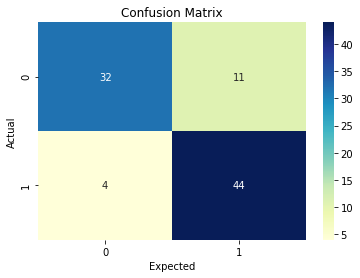

In [123]:
# Fit best model
best = KNeighborsClassifier(n_neighbors=best_k, p=2)
best_model_knn = best.fit(X_train_s,y_train)
train_best_knn = best_model_knn.predict(X_train_s)
test_best_knn = best_model_knn.predict(X_test_s)

# Output results
print("Train accuracy: ", accuracy_score(y_train, train_best_knn))
print("Test accuracy: ", accuracy_score(y_test, test_best_knn))
print(classification_report(y_test,test_best_knn))

sns.heatmap(confusion_matrix(y_test, test_best_knn), annot=True, cmap="YlGnBu")
plt.ylabel("Actual")
plt.xlabel("Expected")
plt.title("Confusion Matrix")
plt.show()

cm = confusion_matrix(y_test, test_best_knn)
results.loc["kNN","Accuracy"] = accuracy_score(y_test, test_best_knn)
results.loc["kNN","Precision"] = cm[0,0]/(cm[0,0]+cm[1,0])
results.loc["kNN","Recall"] = cm[1,1]/(cm[0,1]+cm[1,1])
results.loc["kNN","F1"] = 2*results.loc["kNN","Precision"]*results.loc["kNN","Recall"]/(results.loc["kNN","Precision"]+results.loc["kNN","Recall"])

Using Eucledian distance the optimum number of neighbors is 11. This set up allows to achieve 84% accuracy and 84% F1 score.

## SVM

In [124]:
# Iterate over set of hyperparameters:
# Create the parameters grid
param_grid = {'C': [0.1,1, 10, 30, 50, 100], 
              'gamma': [1,0.1,0.01,0.001,0.0001],
              'kernel': ['rbf', 'poly', 'sigmoid']}

# Create grid object
grid_search = GridSearchCV(SVC(),param_grid,refit=True)
grid_search.fit(X_train_s,y_train)
print(grid.best_estimator_)
best_est = grid_search.best_estimator_
print(grid_search.best_estimator_.get_params()['kernel'])

SVC(C=30, gamma=0.0001)
rbf


Train accuracy:  0.8436018957345972
Test accuracy:  0.8681318681318682
              precision    recall  f1-score   support

           0       0.92      0.79      0.85        43
           1       0.83      0.94      0.88        48

    accuracy                           0.87        91
   macro avg       0.88      0.86      0.87        91
weighted avg       0.87      0.87      0.87        91



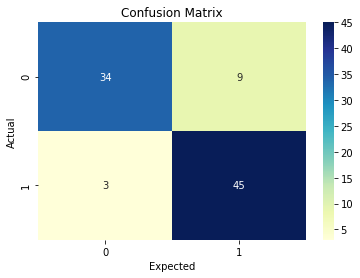

In [125]:
# Fit best model
train_best_svm = grid.predict(X_train_s)
test_best_svm = grid.predict(X_test_s)

# Output results
print("Train accuracy: ", accuracy_score(y_train, train_best_svm))
print("Test accuracy: ", accuracy_score(y_test, test_best_svm))
print(classification_report(y_test,test_best_svm))

sns.heatmap(confusion_matrix(y_test, test_best_svm), annot=True, cmap="YlGnBu")
plt.ylabel("Actual")
plt.xlabel("Expected")
plt.title("Confusion Matrix")
plt.show()

cm = confusion_matrix(y_test, test_best_svm)
results.loc["SVM","Accuracy"] = accuracy_score(y_test, test_best_svm)
results.loc["SVM","Precision"] = cm[0,0]/(cm[0,0]+cm[1,0])
results.loc["SVM","Recall"] = cm[1,1]/(cm[0,1]+cm[1,1])
results.loc["SVM","F1"] = 2*results.loc["SVM","Precision"]*results.loc["SVM","Recall"]/(results.loc["SVM","Precision"]+results.loc["SVM","Recall"])


Selected model for SVM uses radial basis function, regularisation parameter of 30 and gamma of 0.001. Model Accuracy 87%

## Results

In [126]:
results.style.format({'Accuracy': "{:.2%}",'Precision': "{:.2%}",'Recall': "{:.2%}",'F1': "{:.2%}"})

,Accuracy,Precision,Recall,F1
DTree,79.12%,90.00%,73.77%,81.08%
RFC,83.52%,91.18%,78.95%,84.62%
Logistic,85.71%,89.47%,83.02%,86.13%
kNN,83.52%,88.89%,80.00%,84.21%
SVM,86.81%,91.89%,83.33%,87.40%


SVM model has shown best results among 3 metrics. However the final model selection would be based on the accuracy-complexity trade-off depending on use of the model.